In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, basename
import pickle
from scipy.stats import pearsonr
from scipy.signal import periodogram, filtfilt, spectrogram
import seaborn as sns

from filtering import freq_filt

In [2]:
banner_coords = (44.3, -115.233)
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v2.csv')
from shapely import wkt
res['geometry'] = res['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(res, geometry = 'geometry', crs = 'EPSG:4326')

data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'
with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [3]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/psd_results'
with open(join(result_dir, 'avg_Pxx.pkl'), 'rb') as f:
    avg_Pxx = pickle.load(f)
with open(join(result_dir, 'pre_avg_Pxx.pkl'), 'rb') as f:
    pre_avg_Pxx  = pickle.load(f)

# Plotting

([], [])

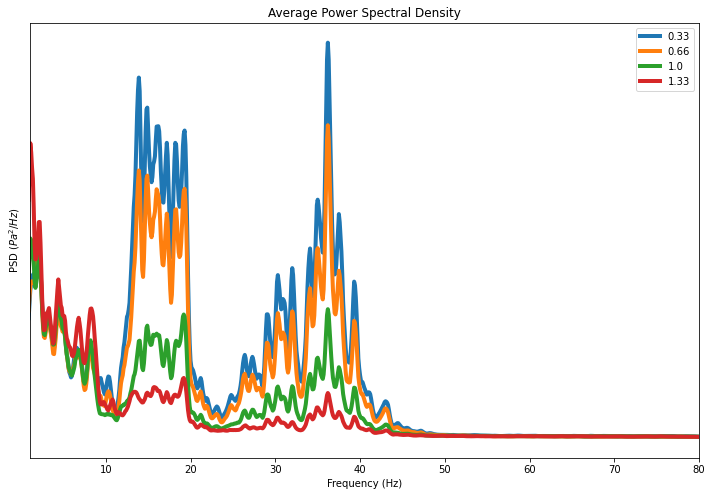

In [5]:
f, ax = plt.subplots(figsize = (12,8))
(avg_Pxx)[[0.33,0.66,1,1.33]].plot(linewidth = 4, ax = ax)
plt.xlim(1, 80)
plt.title('Average Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Pa^{2}/Hz$)')
plt.yticks([])

([], [])

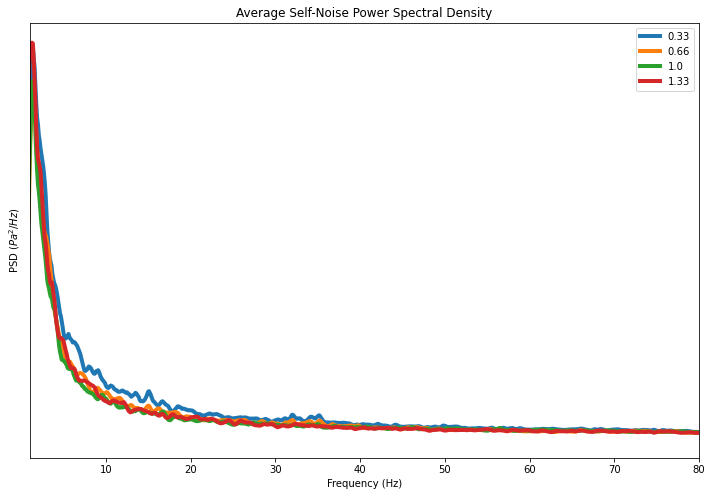

In [7]:
f, ax = plt.subplots(figsize = (12,8))
(pre_avg_Pxx)[[0.33,0.66,1,1.33]].plot(linewidth = 4, ax = ax)
plt.xlim(1, 80)
plt.title('Average Self-Noise Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Pa^{2}/Hz$)')
# plt.yscale('log')
plt.yticks([])

([], [])

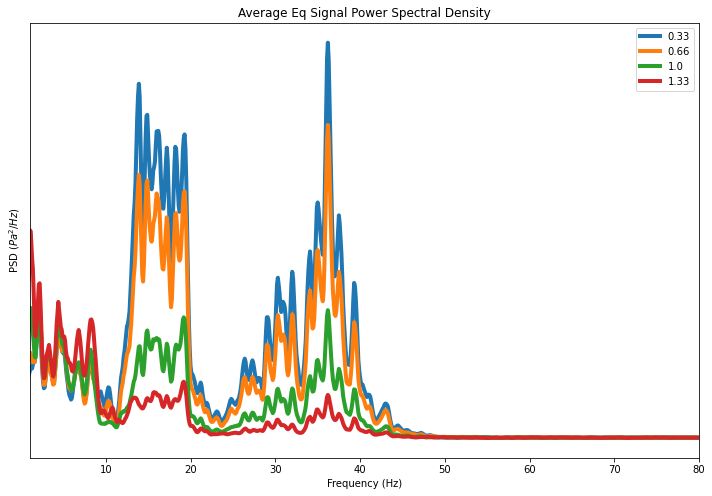

In [11]:
f, ax = plt.subplots(figsize = (12,8))
(avg_Pxx- pre_avg_Pxx)[[0.33,0.66,1,1.33]].plot(linewidth = 4, ax = ax)
plt.xlim(1, 80)
plt.title('Average Eq Signal Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Pa^{2}/Hz$)')
plt.yticks([])

In [16]:
comb

,0.33,0.66,1.00,1.33,2.00
0.0,-2.295956e-23,2.152791e-24,-1.643756e-25,-2.067952e-25,-1.285736e-22
0.1,4.305608e-07,3.384108e-07,1.766325e-07,7.658658e-08,2.279150e-06
0.2,7.963916e-07,6.251264e-07,2.997565e-07,9.565553e-08,2.813959e-05
0.3,1.228846e-06,1.012317e-06,7.106407e-07,4.693878e-07,9.534386e-05
0.4,1.739487e-06,1.515941e-06,1.423215e-06,1.312834e-06,1.729178e-04
...,...,...,...,...,...
99.6,1.646707e-10,1.480654e-10,1.052626e-10,1.472083e-10,6.521422e-10
99.7,1.530757e-10,1.356501e-10,9.862596e-11,1.392355e-10,6.127476e-10
99.8,1.367477e-10,1.187779e-10,8.839135e-11,1.261347e-10,5.471487e-10
99.9,1.147693e-10,9.767357e-11,7.568316e-11,1.074177e-10,4.551560e-10


In [23]:
comb[comb[1.33]<1e-8] = np.nan

Text(0, 0.5, 'PSD Ratio Relative to 1.33m Sensor')

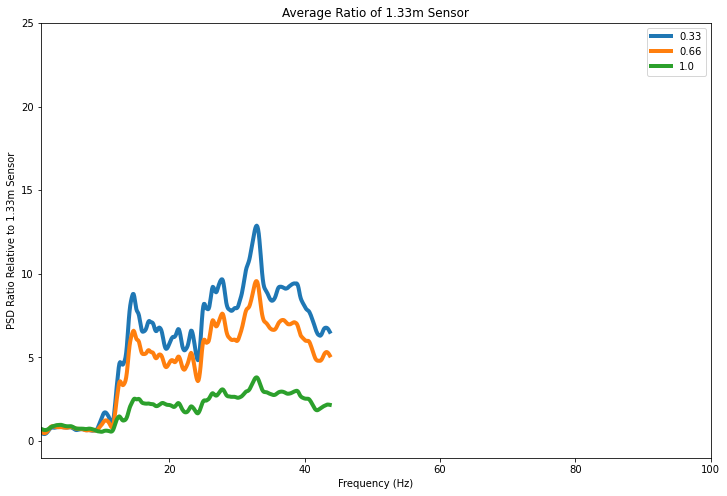

In [26]:
f, ax = plt.subplots(figsize = (12,8))
comb = avg_Pxx- pre_avg_Pxx
comb[comb[1.33]<1e-9] = np.nan
comb = comb.rolling(10).mean()
(comb)[[0.33,0.66,1]].div((comb)[1.33], axis = 0).plot(linewidth = 4, ax = ax)
plt.xlim(1, 100)
plt.ylim(-1, 25)
plt.title('Average Ratio of 1.33m Sensor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD Ratio Relative to 1.33m Sensor')

# Outdated

## Average PSD

In [4]:
## This one doesn't normalize by pre PSD to remove sensor self noise
n = 0
avg_Pxx = np.array([])
for i, r in res[res.selected == 1].iterrows():
    if i == i:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        s = pd.to_datetime(r.time) + pd.Timedelta('3 second')
        e = s + pd.Timedelta('10 second')
        try:
            if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
                for name, fp in day.items():
                    if name != 'snotel':
                        arr = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), 1, kind = 'highpass')
                        arr = arr[:2000]
                        f, Pxx = periodogram(arr, sps, scaling = 'density')
                        Pxx = filtfilt([1,1,1,1,1],5, Pxx)
                        sig[name] = Pxx
                df = pd.DataFrame(sig)
                df.index = f
                if avg_Pxx.size == 0:
                    avg_Pxx = df
                else:
                    avg_Pxx = avg_Pxx + df
                    n +=1
        except ValueError as e:
            print(dt)
            print(e)

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


: 

: 

In [3]:
## This one does normalize by pre PSD to remove sensor self noise
n = 0
avg_Pxx = np.array([])
for i, r in res[res.selected == 1].iterrows():
    if i == i:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        s = pd.to_datetime(r.time) + pd.Timedelta('3 second')
        e = s + pd.Timedelta('10 second')
        pe = pd.to_datetime(r.time)
        ps = pe - pd.Timedelta('10 second')
        try:
            if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
                for name, fp in day.items():
                    if name != 'snotel':
                        arr = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), 1, kind = 'highpass')
                        pre = freq_filt(pd.read_parquet(fp)[ps:pe].values.ravel(), 1, kind = 'highpass')
                        pre = pre[:2000]
                        arr = arr[:2000]
                        f, Pxx = periodogram(arr, sps, scaling = 'density')
                        f, pre_Pxx = periodogram(pre, sps, scaling = 'density')
                        Pxx = Pxx - pre_Pxx
                        Pxx = filtfilt([1,1,1,1,1],5, Pxx)
                        sig[name] = Pxx
                df = pd.DataFrame(sig)
                df.index = f
                if avg_Pxx.size == 0:
                    avg_Pxx = df
                else:
                    avg_Pxx = avg_Pxx + df
                    n +=1
                # plt.xlim(0, 50)      
        except ValueError as e:
            print(dt)
            print(e)

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


: 

: 

([], [])

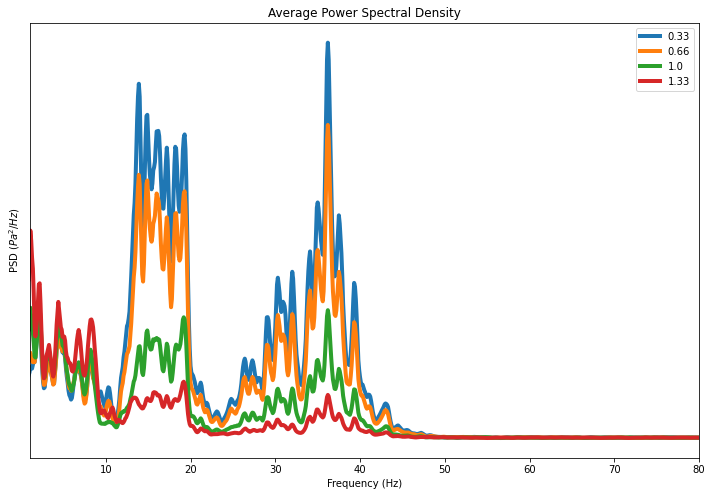

In [ ]:
f, ax = plt.subplots(figsize = (12,8))
(avg_Pxx/n)[[0.33,0.66,1,1.33]].plot(linewidth = 4, ax = ax)
plt.xlim(1, 80)
plt.title('Average Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Pa^{2}/Hz$)')
plt.yticks([])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

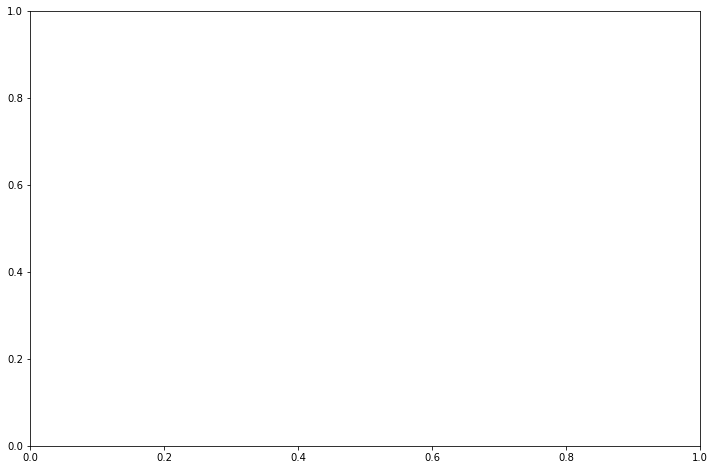

In [34]:
f, ax = plt.subplots(figsize = (12,8))
avg_Pxx[[0.33,0.66,1]].div(avg_Pxx[1.33], axis = 0).plot(linewidth = 4, ax = ax)
plt.xlim(1, 60)
plt.ylim(-1, 30)
plt.title('Average Ratio of 1.33m Sensor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD Ratio Relative to 1.33m Sensor')

# Ratio figure

In [90]:
from copy import deepcopy
n = 0
avg_ratio = np.array([])
for i, r in res[res.selected == 1].iterrows():
    if i == i:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        s = pd.to_datetime(r.time) + pd.Timedelta('3 second')
        e = s + pd.Timedelta('10 second')
        pe = pd.to_datetime(r.time)
        ps = pe - pd.Timedelta('10 second')
        try:
            if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
                for name, fp in day.items():
                    if name != 'snotel':
                        arr = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), .1, kind = 'highpass')
                        pre = freq_filt(pd.read_parquet(fp)[ps:pe].values.ravel(), 1, kind = 'highpass')
                        pre = pre[:2000]
                        arr = arr[:2000]
                        f, Pxx = periodogram(arr, sps, scaling = 'density')
                        f, pre_Pxx = periodogram(pre, sps, scaling = 'density')
                        Pxx = Pxx - pre_Pxx
                        Pxx = filtfilt([1,1,1,1,1],5, Pxx)
                        sig[name] = Pxx
                df = pd.DataFrame(sig)
                df = df[[0.33, 0.66, 1, 1.33]]
                top = df[1.33]
                top[top < 1e-12] = np.nan
                valid = deepcopy(top)
                valid[~np.isnan(valid)] = 1
                valid[np.isnan(valid)] = 0
                df = df.div(top, axis = 0).drop([1.33], axis = 1).iloc[1:]
                df.index = f[1:]
                df = np.nan_to_num(df)
                if avg_ratio.size == 0:
                    avg_ratio = df
                    valid_n = valid 
                else:
                    avg_ratio = avg_ratio + df
                    n +=1    
                    valid_n = np.add(valid_n, valid)
        except ValueError as e:
            print(dt)
            print(e)

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


Text(0, 0.5, 'PSD Ratio Relative to 1.33m Sensor')

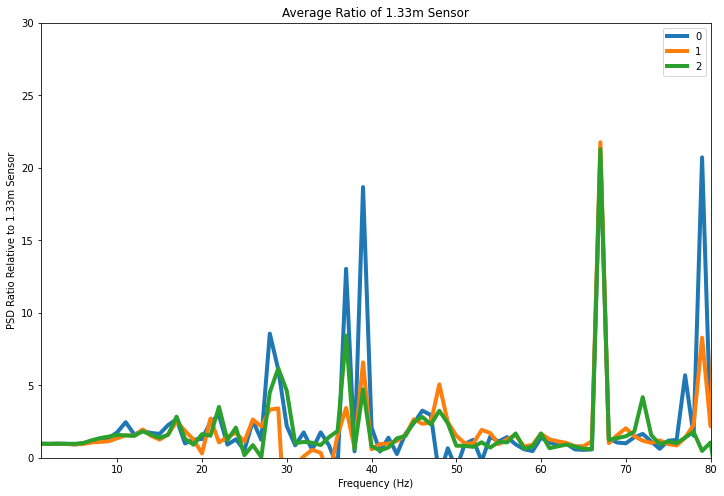

In [91]:
f, ax = plt.subplots(figsize = (12,8))
pd.DataFrame(avg_ratio / valid_n.values[1:].reshape(-1,1)).plot(linewidth = 4, ax = ax)

plt.xlim(1, 80)
plt.ylim(0, 30)
plt.title('Average Ratio of 1.33m Sensor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD Ratio Relative to 1.33m Sensor')

# Pre PSD

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


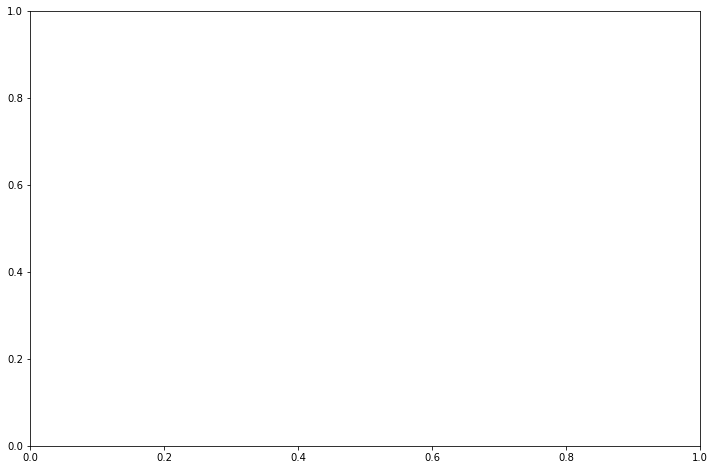

In [ ]:
n = 0
pre_avg_Pxx = np.array([])
for i, r in res[res.selected == 1].iterrows():
    if i == i:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        pe = pd.to_datetime(r.time)
        ps = pe - pd.Timedelta('10 second')
        try:
            if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
                for name, fp in day.items():
                    if name != 'snotel':
                        pre = freq_filt(pd.read_parquet(fp)[ps:pe].values.ravel(), 1, kind = 'highpass')
                        pre = pre[:2000]
                        f, pre_Pxx = periodogram(pre, sps, scaling = 'density')
                        pre_Pxx = filtfilt([1,1,1,1,1],5, pre_Pxx)
                        sig[name] = pre_Pxx
                df = pd.DataFrame(sig)
                df.index = f
                if pre_avg_Pxx.size == 0:
                    pre_avg_Pxx = df
                else:
                    pre_avg_Pxx = pre_avg_Pxx + df
                    n +=1  
        except ValueError as e:
            print(dt)
            print(e)

([], [])

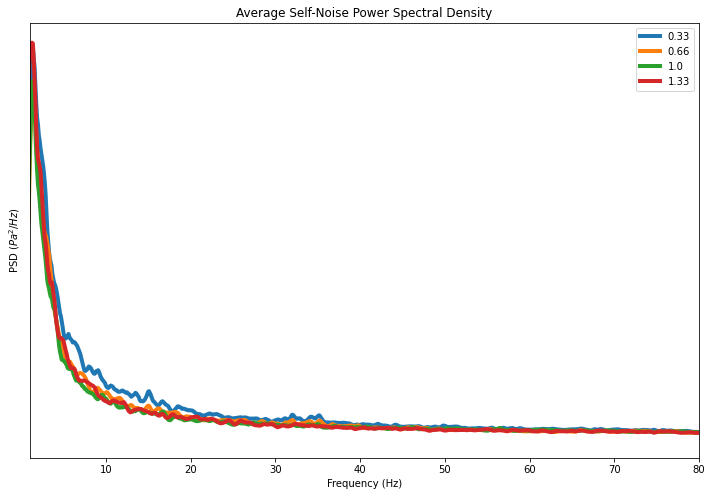

In [ ]:
f, ax = plt.subplots(figsize = (12,8))
(pre_avg_Pxx/n)[[0.33,0.66,1,1.33]].plot(linewidth = 4, ax = ax)
plt.xlim(1, 80)
plt.title('Average Self-Noise Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Pa^{2}/Hz$)')
# plt.yscale('log')
plt.yticks([])

# Each EQ PSD

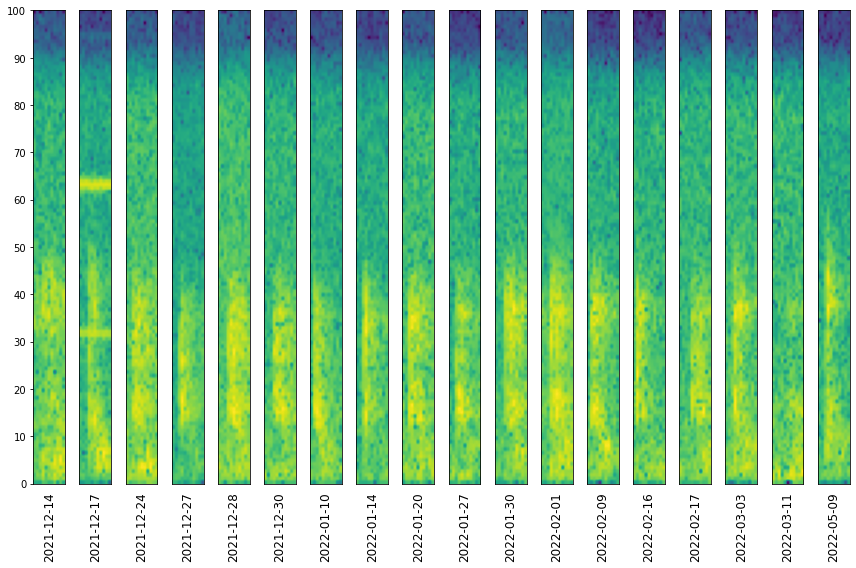

In [33]:
eqs= 18
n = 0
f, axes = plt.subplots(1, eqs, figsize = (12,8))
for i, r in res[(res.selected == 1) & (res.mean_ratio > 5)][::-1].iterrows():
    if n < eqs:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        sig = {}
        s = pd.to_datetime(r.time) + pd.Timedelta('1 second')
        e = s + pd.Timedelta('8 second')
        try:
            if 1 in day.keys():
                    fp = day[1]
                    arr = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), 1, kind = 'highpass')
                    arr = arr[:2000]
                    ax = axes[n]
                    Sxx, f, t, im = ax.specgram(arr, Fs = sps)
                    ax.set_xticks([])
                    ax.set_xlabel(dt, rotation = 90, fontsize = 12)
                    day['snotel']['Snow Depth (cm) Start of Day Values']
                    if n == 0:
                        ax.set_yticks(np.linspace(0,100,11))
                    else:
                        ax.set_yticks([])
                    n += 1
        except ValueError as e:
            print(dt)
            print(e)
plt.tight_layout()